<a href="https://colab.research.google.com/github/H2IA/escola-de-verao-2021/blob/main/Classificando_Imagens_com_Pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Classificando imagens com o PyTorch

Agora vamos exemplificar a classificação de imagens usando redes neurais convolucionais. Para isso vamos utilizar o conjunto de dados de pássaros anotado e revisado na aula anterior, contendo imagens categorizadas em: `cardeal`, `joao-de-barro` e `sabia`.

## Obtendo o *dataset*

In [1]:
import torch
from torchvision.datasets import DatasetFolder
from torch.utils.data import DataLoader
import torchvision.transforms as transforms

Diferente dos datasets de dados tabulares geralmente utilizados para fins didáticos, datasets de imagens tendem a ocupar muito mais espaço em memória, sendo mais apropriado se carregar os dados em *chunks* (também chamados *batches*) ao invés de se alocar tudo na memória durante o treinamento.

In [2]:
!mkdir -p data/
!wget -O data/h2ia-birds-dataset.tar.gz https://www.dropbox.com/s/63w2fkwprvsu94a/h2ia-birds-dataset.tar.gz?dl=1
!cd data && tar -xvf h2ia-birds-dataset.tar.gz && mv h2ia-birds-dataset birds

--2021-02-25 21:39:20--  https://www.dropbox.com/s/63w2fkwprvsu94a/h2ia-birds-dataset.tar.gz?dl=1
Resolving www.dropbox.com (www.dropbox.com)... 162.125.1.18, 2620:100:601a:18::a27d:712
Connecting to www.dropbox.com (www.dropbox.com)|162.125.1.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/dl/63w2fkwprvsu94a/h2ia-birds-dataset.tar.gz [following]
--2021-02-25 21:39:20--  https://www.dropbox.com/s/dl/63w2fkwprvsu94a/h2ia-birds-dataset.tar.gz
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc706b1fcb7489763bb986ac8b05.dl.dropboxusercontent.com/cd/0/get/BJrqopOArNNdosiva7inpZp53H9fB2pKhMkdeTftzUQuF4YH_j4UysAAeyFeq6jW3Bu6aH02DQZeFNrrZjTvcGCjhjKh5THRDpeyN3ZyHjpSPaWIeiZ0j9dgN_80qaO47fQ/file?dl=1# [following]
--2021-02-25 21:39:20--  https://uc706b1fcb7489763bb986ac8b05.dl.dropboxusercontent.com/cd/0/get/BJrqopOArNNdosiva7inpZp53H9fB2pKhMkdeTftzUQuF4YH_j4UysAAeyFeq6jW3Bu6aH

Os dados passarão por uma *pipeline* de transformação antes de serem passados para a rede neural. Esta *pipeline* é criada com a classe `torchvision.transforms.Compose` do `Torchvision`, e inclui duas etapas: 

- conversão dos dados para tensores;
- normalização dos dados considerando média e desvio padrão iguais a 0.5;

In [3]:
transformers = transforms.Compose([
    transforms.Resize(128),
    transforms.CenterCrop(128),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

Com os dados baixados podemos criar objetos da classe `DataLoader`, que intermediarão o carregamento dos dados durante o treinamento, de modo similar a objetos interáveis.

In [4]:
from torchvision.datasets import ImageFolder

train_data   = ImageFolder(root='data/birds/train', transform=transformers)
train_loader = DataLoader(train_data, batch_size=8, shuffle=True,  num_workers=4)

test_data   = ImageFolder(root='data/birds/test', transform=transformers)
test_loader = DataLoader(test_data, batch_size=8, shuffle=True,  num_workers=4)

## Treinando um modelo simples: LeNet

Agora podemos criar a classe da nossa rede neural convolucional usando como base a classe `nn.Module`. Da mesma forma como vimos anteriormente, definimos no método construtor `__init__` as nossas camadas e as suas conexão através do método `forward`. 

Para exemplificar a criação de uma rede convolucional, vamos implementar com o Torch uma rede baseada na LeNet, originalmente descrita por [LeCun *et al* (1989)](https://doi.org/10.1162%2Fneco.1989.1.4.541).

In [5]:
from torch import nn
import torch.nn.functional as F

In [6]:
class LeNet(nn.Module):
	def __init__(self):
		super(LeNet, self).__init__()
		self.conv1 = nn.Conv2d(3, 6, (5,5), padding=2)
		self.conv2 = nn.Conv2d(6, 16, (5,5))
		self.fc1   = nn.Linear(14400, 120)
		self.fc2   = nn.Linear(120, 84)
		self.fc3   = nn.Linear(84, 3)
	def forward(self, x):
		x = F.max_pool2d(F.relu(self.conv1(x)), (2,2))
		#x = F.dropout(x)
		x = F.max_pool2d(F.relu(self.conv2(x)), (2,2))
		#x = F.dropout(x)
		x = x.view(-1, self.num_flat_features(x))
		x = F.relu(self.fc1(x))
		x = F.relu(self.fc2(x))
		x = self.fc3(x)
		return x
	def num_flat_features(self, x):
		size = x.size()[1:]
		num_features = 1
		for s in size:
			num_features *= s
		return num_features

net = LeNet()

In [7]:
net = net.to('cuda')

Agora vamos cria rum otimizador, que será responsável pelo ajuste dos pesos dos neurônios da rede. Para isso utilizaremos o gradiente descendente estocástico (*stochastic gradient descent*, SGD) usando como métrica de erro a entropia cruzada (*cross entropy*). 

In [8]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.01)

Agora iniciamos o ciclo de treinamento, que é sub-dividido em *épocas*. Em cada época todos os exemplos de treinamento são processados pelo rede, sendo o erro da predição usado para o ajuste dos parâmetros pelo otimizador.

In [9]:
import warnings
import numpy as np

warnings.simplefilter('ignore')

train_history_loss = []

for epoch in range(20):

  for i, data in enumerate(train_loader):

    inputs, labels = data
    optimizer.zero_grad()
    outputs = net(inputs.to('cuda'))
    train_loss = criterion(outputs, labels.to('cuda'))
    train_loss.backward()
    optimizer.step()

    train_history_loss.append(train_loss.item())
    print(f'epoch: {epoch}', f'step: {i}', f'loss: {train_history_loss[-1]}')

epoch: 0 step: 0 loss: 1.0965813398361206
epoch: 0 step: 1 loss: 1.0871284008026123
epoch: 0 step: 2 loss: 1.1043957471847534
epoch: 0 step: 3 loss: 1.0842373371124268
epoch: 0 step: 4 loss: 1.0529804229736328
epoch: 0 step: 5 loss: 1.0905921459197998
epoch: 0 step: 6 loss: 1.1047849655151367
epoch: 0 step: 7 loss: 1.1253697872161865
epoch: 0 step: 8 loss: 1.0954326391220093
epoch: 0 step: 9 loss: 1.1048448085784912
epoch: 0 step: 10 loss: 1.0972766876220703
epoch: 0 step: 11 loss: 1.0936908721923828
epoch: 0 step: 12 loss: 1.0725206136703491
epoch: 0 step: 13 loss: 1.096419095993042
epoch: 0 step: 14 loss: 1.1126813888549805
epoch: 0 step: 15 loss: 1.097641944885254
epoch: 0 step: 16 loss: 1.1454991102218628
epoch: 0 step: 17 loss: 1.099584937095642
epoch: 0 step: 18 loss: 1.0929347276687622
epoch: 0 step: 19 loss: 1.064049243927002
epoch: 0 step: 20 loss: 1.1370501518249512
epoch: 0 step: 21 loss: 1.1287931203842163
epoch: 0 step: 22 loss: 1.1029316186904907
epoch: 0 step: 23 loss: 1

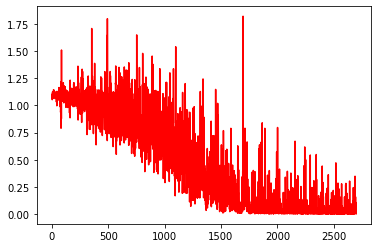

In [10]:
from matplotlib import pyplot as plt

plt.plot(train_history_loss, color='red')

## Avaliando o modelo

Para avaliar o nosso modelo vamos utilizar o conjunto de dados de teste que é carregado com o iterável `test_loader`. Vamos percorrer os *batches* de dados e acumular as predições e rótulos verdadeiros nas listas `y_pred` e `y_test` respectivamente.

In [11]:
with torch.no_grad():

  y_test, y_pred = [], []

  for data in test_loader:

      X_test_batch, y_test_batch  = data
      y_pred_raw_batch            = net(X_test_batch.to('cuda')).cpu()
      _, y_pred_batch             = torch.max(y_pred_raw_batch, 1)

      y_test += list([x.item() for x in y_test_batch])
      y_pred += list([x.item() for x in y_pred_batch])

A acurácia "geral" é a métrica mais simples para avaliarmos classificares, mas geralmente é pouco informativa para classificadores multi-classe. Para computar ela podemos utilizar a função `accuracy_score` disponível no módulo `sklearn.metrics`.

In [12]:
from sklearn.metrics import accuracy_score

accuracy_score(y_test, y_pred)

0.6712707182320442

Para calcularmos a acurácia de cada classe podemos utilizar uma matriz de confusão utilizando a função `classification_report` do módulo `sklearn.metrics` e a partir dela calcular a acurácia de cada classe.

In [13]:
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.87      0.57      0.69       160
           1       0.74      0.80      0.77       129
           2       0.41      0.66      0.51        73

    accuracy                           0.67       362
   macro avg       0.67      0.68      0.66       362
weighted avg       0.73      0.67      0.68       362



## Treinando um modelo mais complexo: AlexNet

Para melhorarmos a performance da rede podemos testar arquiteturas de redes com mais camandas convolucionais, como a AlexNet ([Krizhevsky *et al* 2017](https://dl.acm.org/doi/10.1145/3065386)). Estes redes conseguem "aprender" representações mais complexas por conta do maior número de camadas e parâmetros, mas também exigem um maior volume de dados e também maior tempo de computação. 

In [14]:
class AlexNet(nn.Module):

    def __init__(self, num_classes: int = 1000) -> None:
        super(AlexNet, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=11, stride=4, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(64, 192, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
        )
        self.avgpool = nn.AdaptiveAvgPool2d((6, 6))
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(256 * 6 * 6, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, num_classes),
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x


net = AlexNet(num_classes=3).to('cuda')

In [15]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.01)

In [16]:
train_history_loss = []

for epoch in range(100):

  for i, data in enumerate(train_loader):

    inputs, labels = data
    optimizer.zero_grad()
    outputs = net(inputs.to('cuda'))
    train_loss = criterion(outputs.to('cuda'), labels.to('cuda'))
    train_loss.backward()
    optimizer.step()

    train_history_loss.append(train_loss.item())

    print(epoch, train_history_loss[-1])

A saída de streaming foi truncada nas últimas 5000 linhas.
62 0.07226429134607315
62 0.0003391285426914692
62 0.0003173833538312465
62 4.545926276477985e-05
62 0.00043196635670028627
63 0.12407946586608887
63 0.0004978645592927933
63 4.1347233491251245e-05
63 8.823144889902323e-05
63 0.0014735563891008496
63 0.0014598724665120244
63 0.001388235716149211
63 0.00033734188764356077
63 0.09668600559234619
63 0.0006240427028387785
63 2.4794566343189217e-05
63 9.517773287370801e-05
63 0.0003569651744328439
63 0.0016010567778721452
63 0.0004971904563717544
63 0.0005923924618400633
63 0.0793536826968193
63 7.60143157094717e-05
63 0.1212645024061203
63 0.0002100517594953999
63 0.00011186070332769305
63 0.0006126220105215907
63 0.09369701147079468
63 0.00017453765030950308
63 0.0015287315472960472
63 0.00010242937423754483
63 0.0016097326297312975
63 8.363146480405703e-05
63 0.002681129379197955
63 0.22815673053264618
63 0.000882424064911902
63 0.0002293942088726908
63 0.000145185345900245
63 0.

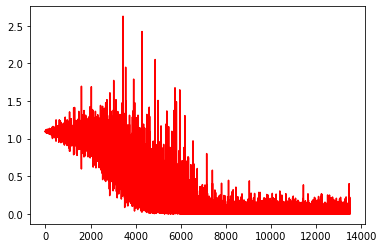

In [17]:
plt.plot(train_history_loss, color='red')

In [18]:
with torch.no_grad():

  y_test, y_pred = [], []

  for data in test_loader:

      X_test_batch, y_test_batch  = data
      y_pred_raw_batch            = net(X_test_batch.to('cuda'))
      _, y_pred_batch             = torch.max(y_pred_raw_batch, 1)

      y_test += list([x.item() for x in y_test_batch])
      y_pred += list([x.item() for x in y_pred_batch])

In [19]:
from sklearn.metrics import classification_report


print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.94      0.81      0.87       160
           1       0.76      0.81      0.78       129
           2       0.58      0.68      0.63        73

    accuracy                           0.78       362
   macro avg       0.76      0.77      0.76       362
weighted avg       0.80      0.78      0.79       362

